# Euclidean Structure of the Overdensity

**Purpose:** Examine the spatial structure of the overdensity using weight-space L2 (Euclidean) distances.

---

## Why Weight Space?

The overdensity spans ±5 exponents, meaning the bfloat16 ULP varies by a factor of 2⁵ = 32 across the structure. Lattice coordinates (W / ULP) are useful for local adjacency questions but break down globally—they're like local coordinate patches in curved spacetime.

**Weight space is the flat background:** uniform, isotropic, and gives honest distances. When we ask "how far apart are these tokens really?" we mean in weight space.

## Metrics

| Metric | Formula | Use |
|--------|---------|-----|
| **L∞ (lattice)** | max(\|ΔW'ᵢ\|) | Local adjacency (are they neighbors on the grid?) |
| **L2 (weight)** | √(Σ ΔWᵢ²) | Global structure (how far apart really?) |

We'll use L∞ in lattice space for adjacency questions and L2 in weight space for distance questions.

In [26]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

# Device detection
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

# Load saved data
DATA_DIR = Path("../../tensors/Qwen3-4B-Instruct-2507")

W = load_file(DATA_DIR / "W_unembed.safetensors")['W'].view(torch.bfloat16)
masks = load_file(DATA_DIR / "masks.safetensors")
neighborhood_mask = masks['neighborhood_mask']

print(f"Loaded W: {W.shape}")
print(f"Neighborhood tokens: {neighborhood_mask.sum().item():,}")

Using device: mps
Loaded W: torch.Size([151936, 2560])
Neighborhood tokens: 2,212


In [27]:
# Extract unique vectors in the overdensity
neighborhood_indices = torch.where(neighborhood_mask)[0]
W_neighborhood = W[neighborhood_indices]

unique_bits, inverse_indices, counts = torch.unique(
    W_neighborhood.view(torch.uint16).to(torch.int32), dim=0,
    return_inverse=True, return_counts=True
)
n_unique = len(unique_bits)
unique_bf16 = unique_bits.to(torch.uint16).view(torch.bfloat16)

# Weight-space coordinates (float32 for precision)
W_unique = unique_bf16.float()  # [N, D]
D = W_unique.shape[1]

print(f"Unique vectors: {n_unique}")
print(f"Dimensionality: {D}")
print(f"Token counts range: [{counts.min().item()}, {counts.max().item()}]")

Unique vectors: 125
Dimensionality: 2560
Token counts range: [1, 814]


## Step 1: Weight-Space L2 Distance Matrix

Compute pairwise Euclidean distances in the flat, uniform weight space.

In [28]:
# Compute pairwise L2 distances in weight space
coords = W_unique.to(device)

diff = coords.unsqueeze(1) - coords.unsqueeze(0)  # [N, N, D]
l2_matrix = torch.sqrt((diff ** 2).sum(dim=2)).cpu()  # [N, N]

print(f"L2 distance matrix computed: {l2_matrix.shape}")
print(f"Distance range: [{l2_matrix.min():.6f}, {l2_matrix.max():.6f}]")

# For context: what's the typical magnitude of these vectors?
norms = torch.norm(W_unique, dim=1)
print(f"\nVector norms (magnitudes):")
print(f"  Mean: {norms.mean():.6f}")
print(f"  Std:  {norms.std():.6f}")
print(f"  Range: [{norms.min():.6f}, {norms.max():.6f}]")

L2 distance matrix computed: torch.Size([125, 125])
Distance range: [0.000000, 0.005591]

Vector norms (magnitudes):
  Mean: 0.370915
  Std:  0.000024
  Range: [0.370653, 0.370957]


## Step 2: Choose a Center

Options:
1. **Biggest black hole** (814 tokens) — the densest point
2. **Medoid** — vector with minimum mean distance to all others
3. **Centroid** — mean position (might be in empty space)

In [29]:
# Find centers
biggest_bh_idx = counts.argmax().item()
print(f"Biggest black hole: idx={biggest_bh_idx}, tokens={counts[biggest_bh_idx].item()}")

# Medoid: vector with minimum mean L2 distance to all others
mean_dist = l2_matrix.mean(dim=1)
medoid_idx = mean_dist.argmin().item()
print(f"Medoid: idx={medoid_idx}, tokens={counts[medoid_idx].item()}, mean_dist={mean_dist[medoid_idx]:.6f}")

# Centroid (float32 mean, not on any lattice point)
centroid = W_unique.mean(dim=0)
dist_from_centroid = torch.norm(W_unique - centroid, dim=1)
print(f"Centroid: mean position in weight space")
print(f"  Nearest vector to centroid: idx={dist_from_centroid.argmin().item()}, dist={dist_from_centroid.min():.6f}")

# How close are the biggest BH and medoid?
bh_medoid_dist = l2_matrix[biggest_bh_idx, medoid_idx].item()
print(f"\nDistance between biggest BH and medoid: {bh_medoid_dist:.6f}")

Biggest black hole: idx=40, tokens=814
Medoid: idx=40, tokens=814, mean_dist=0.000146
Centroid: mean position in weight space
  Nearest vector to centroid: idx=55, dist=0.000051

Distance between biggest BH and medoid: 0.000000


In [30]:
# Use biggest black hole as our center (it's where the mass is)
center_idx = biggest_bh_idx
r = l2_matrix[center_idx].numpy()  # Distance from center for each vector

print(f"Using biggest black hole (idx={center_idx}) as center")
print(f"Distance range from center: [{r.min():.6f}, {r.max():.6f}]")

Using biggest black hole (idx=40) as center
Distance range from center: [0.000000, 0.005495]


## Step 3: Distance Distribution from Center

Histogram the L2 distances. Is it Gaussian? Bimodal? Heavy-tailed?

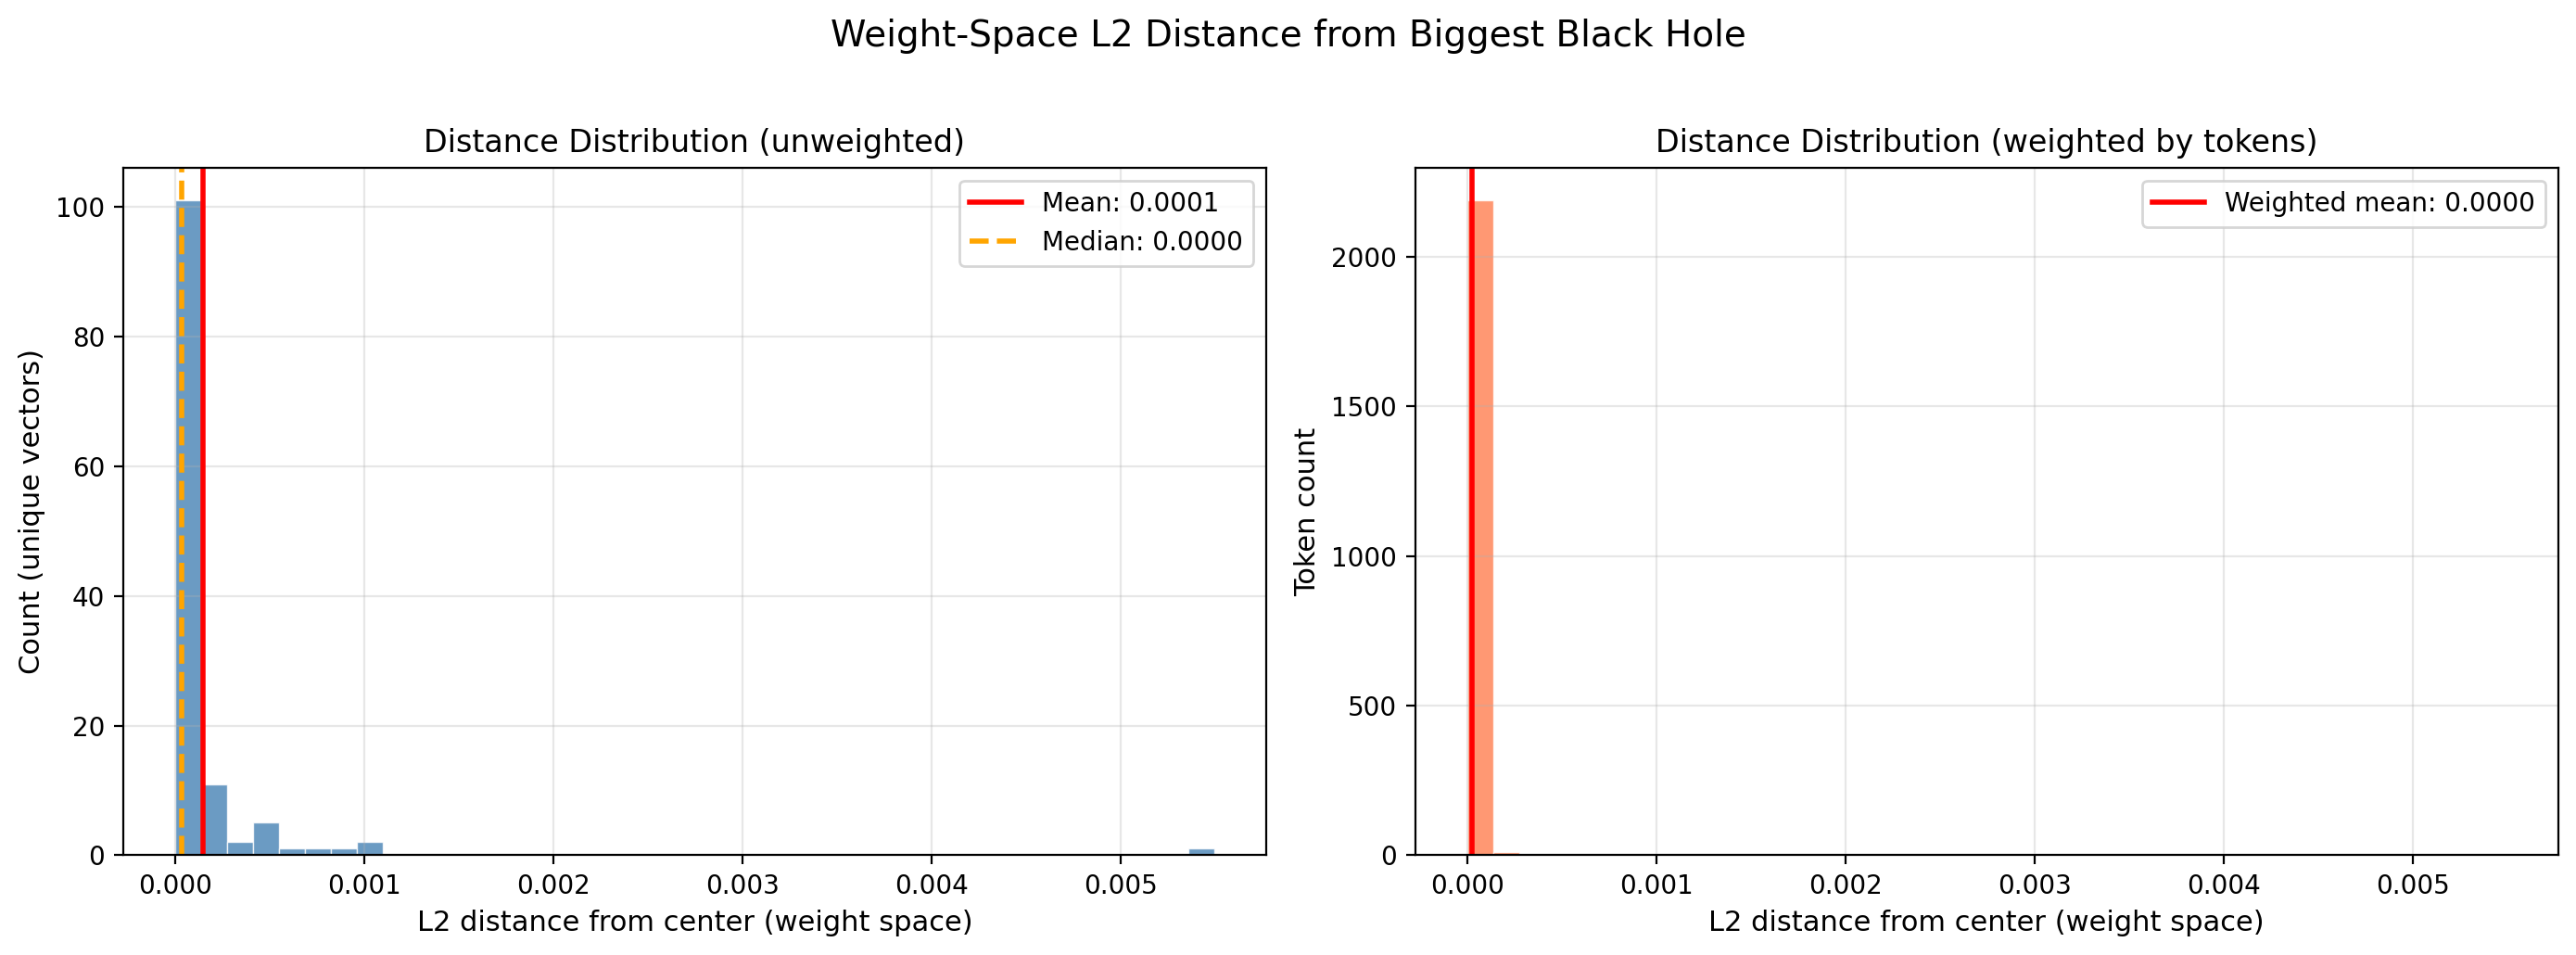

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=200)

# Left: Unweighted (each unique vector counts once)
ax = axes[0]
ax.hist(r, bins=40, color='steelblue', edgecolor='white', linewidth=0.5, alpha=0.8)
ax.axvline(np.mean(r), color='red', linestyle='-', linewidth=2, label=f'Mean: {np.mean(r):.4f}')
ax.axvline(np.median(r), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(r):.4f}')
ax.set_xlabel('L2 distance from center (weight space)', fontsize=11)
ax.set_ylabel('Count (unique vectors)', fontsize=11)
ax.set_title('Distance Distribution (unweighted)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# Right: Weighted by token count
ax = axes[1]
weights = counts.numpy()
ax.hist(r, bins=40, weights=weights, color='coral', edgecolor='white', linewidth=0.5, alpha=0.8)
weighted_mean = np.average(r, weights=weights)
ax.axvline(weighted_mean, color='red', linestyle='-', linewidth=2, label=f'Weighted mean: {weighted_mean:.4f}')
ax.set_xlabel('L2 distance from center (weight space)', fontsize=11)
ax.set_ylabel('Token count', fontsize=11)
ax.set_title('Distance Distribution (weighted by tokens)', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Weight-Space L2 Distance from Biggest Black Hole', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../../notebooks/analysis/weight_l2_histogram.png', dpi=200, bbox_inches='tight')
plt.show()

## Step 4: Scatter Plot — Raw Distance Values

See the actual discrete structure. Each point is a unique vector, positioned by its L2 distance from center.

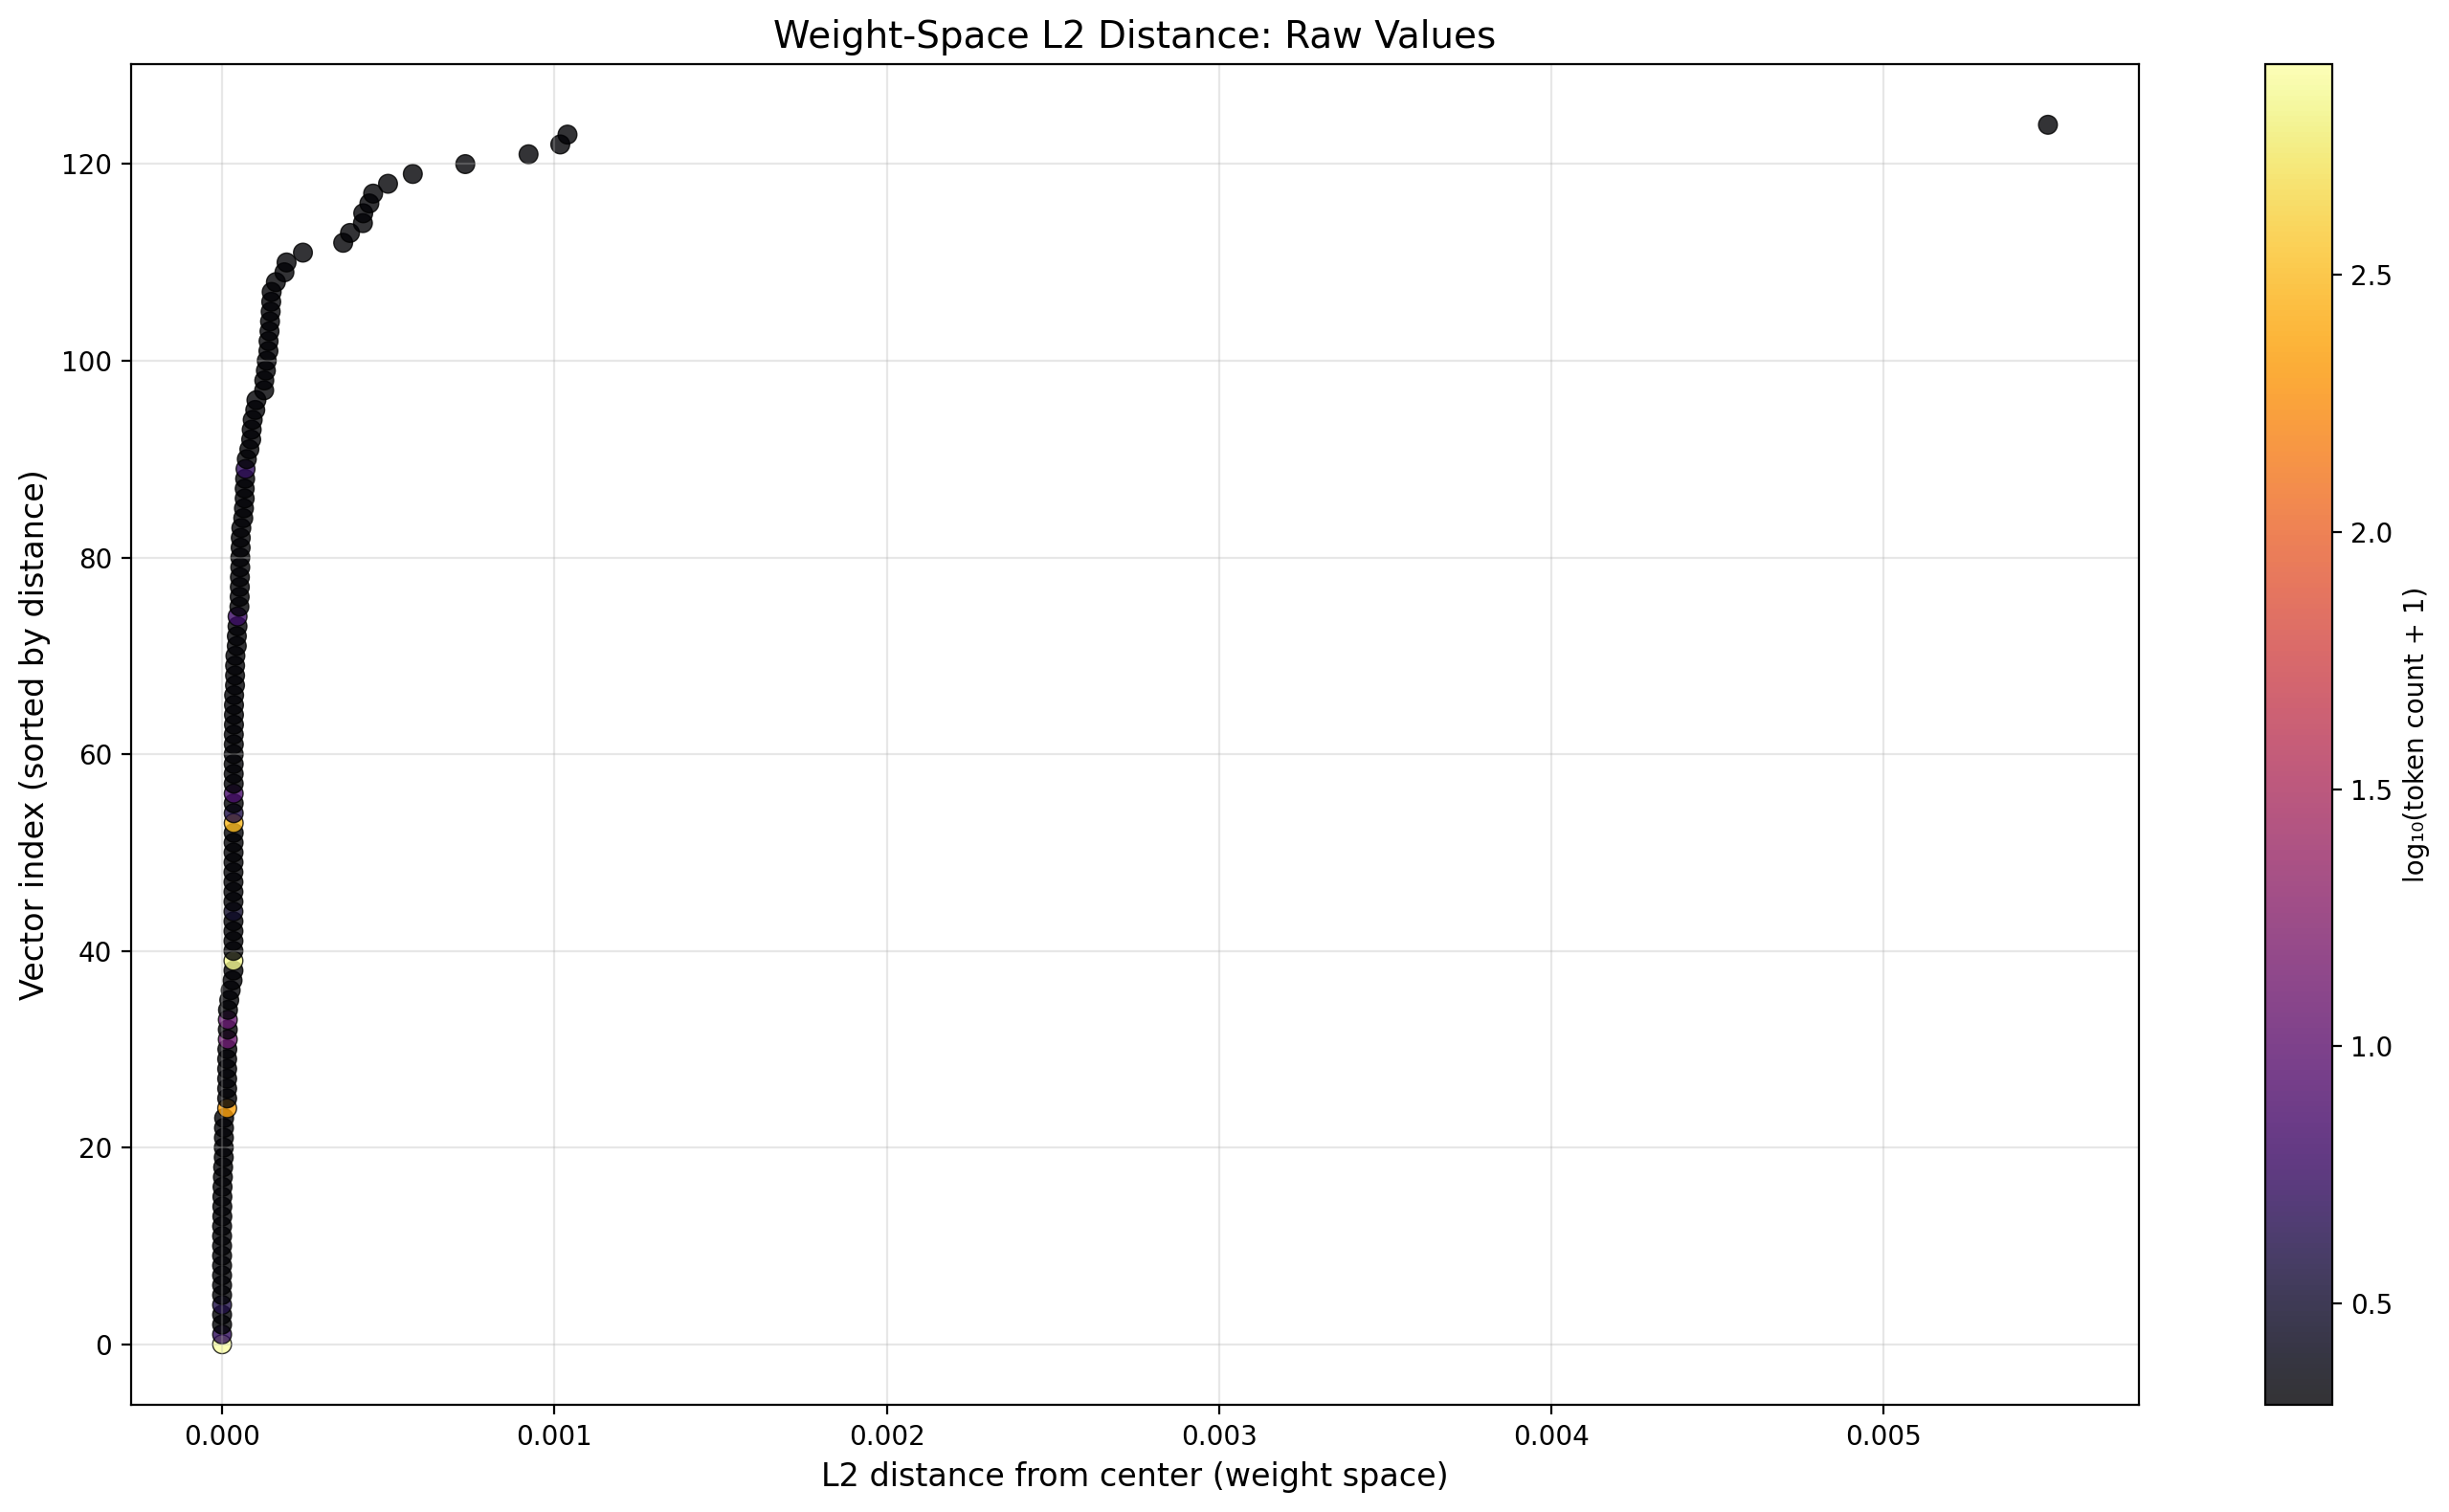


First 20 vectors by distance from center:
  Rank      L2 dist   Tokens
------------------------------
     1     0.000000      814
     2     0.000000        4
     3     0.000000        1
     4     0.000000        1
     5     0.000000        3
     6     0.000000        1
     7     0.000000        1
     8     0.000000        1
     9     0.000000        1
    10     0.000000        1
    11     0.000000        1
    12     0.000000        1
    13     0.000000        1
    14     0.000001        1
    15     0.000001        1
    16     0.000001        1
    17     0.000001        1
    18     0.000002        1
    19     0.000003        1
    20     0.000005        1


In [32]:
# Sort by distance
sorted_idx = np.argsort(r)
r_sorted = r[sorted_idx]
counts_sorted = counts.numpy()[sorted_idx]

fig, ax = plt.subplots(figsize=(14, 8), dpi=200)

colors = np.log10(counts_sorted + 1)
scatter = ax.scatter(r_sorted, np.arange(len(r_sorted)), 
                     c=colors, cmap='inferno', s=50, alpha=0.8,
                     edgecolors='black', linewidths=0.5)

ax.set_xlabel('L2 distance from center (weight space)', fontsize=12)
ax.set_ylabel('Vector index (sorted by distance)', fontsize=12)
ax.set_title('Weight-Space L2 Distance: Raw Values', fontsize=14)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('log₁₀(token count + 1)', fontsize=10)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../../notebooks/analysis/weight_l2_scatter.png', dpi=200, bbox_inches='tight')
plt.show()

# Print first 20 values
print("\nFirst 20 vectors by distance from center:")
print(f"{'Rank':>6} {'L2 dist':>12} {'Tokens':>8}")
print("-" * 30)
for i in range(min(20, len(r_sorted))):
    print(f"{i+1:>6} {r_sorted[i]:>12.6f} {counts_sorted[i]:>8}")

## Step 5: Zoomed View of the Core

Zoom in on the dense inner region to see fine structure.

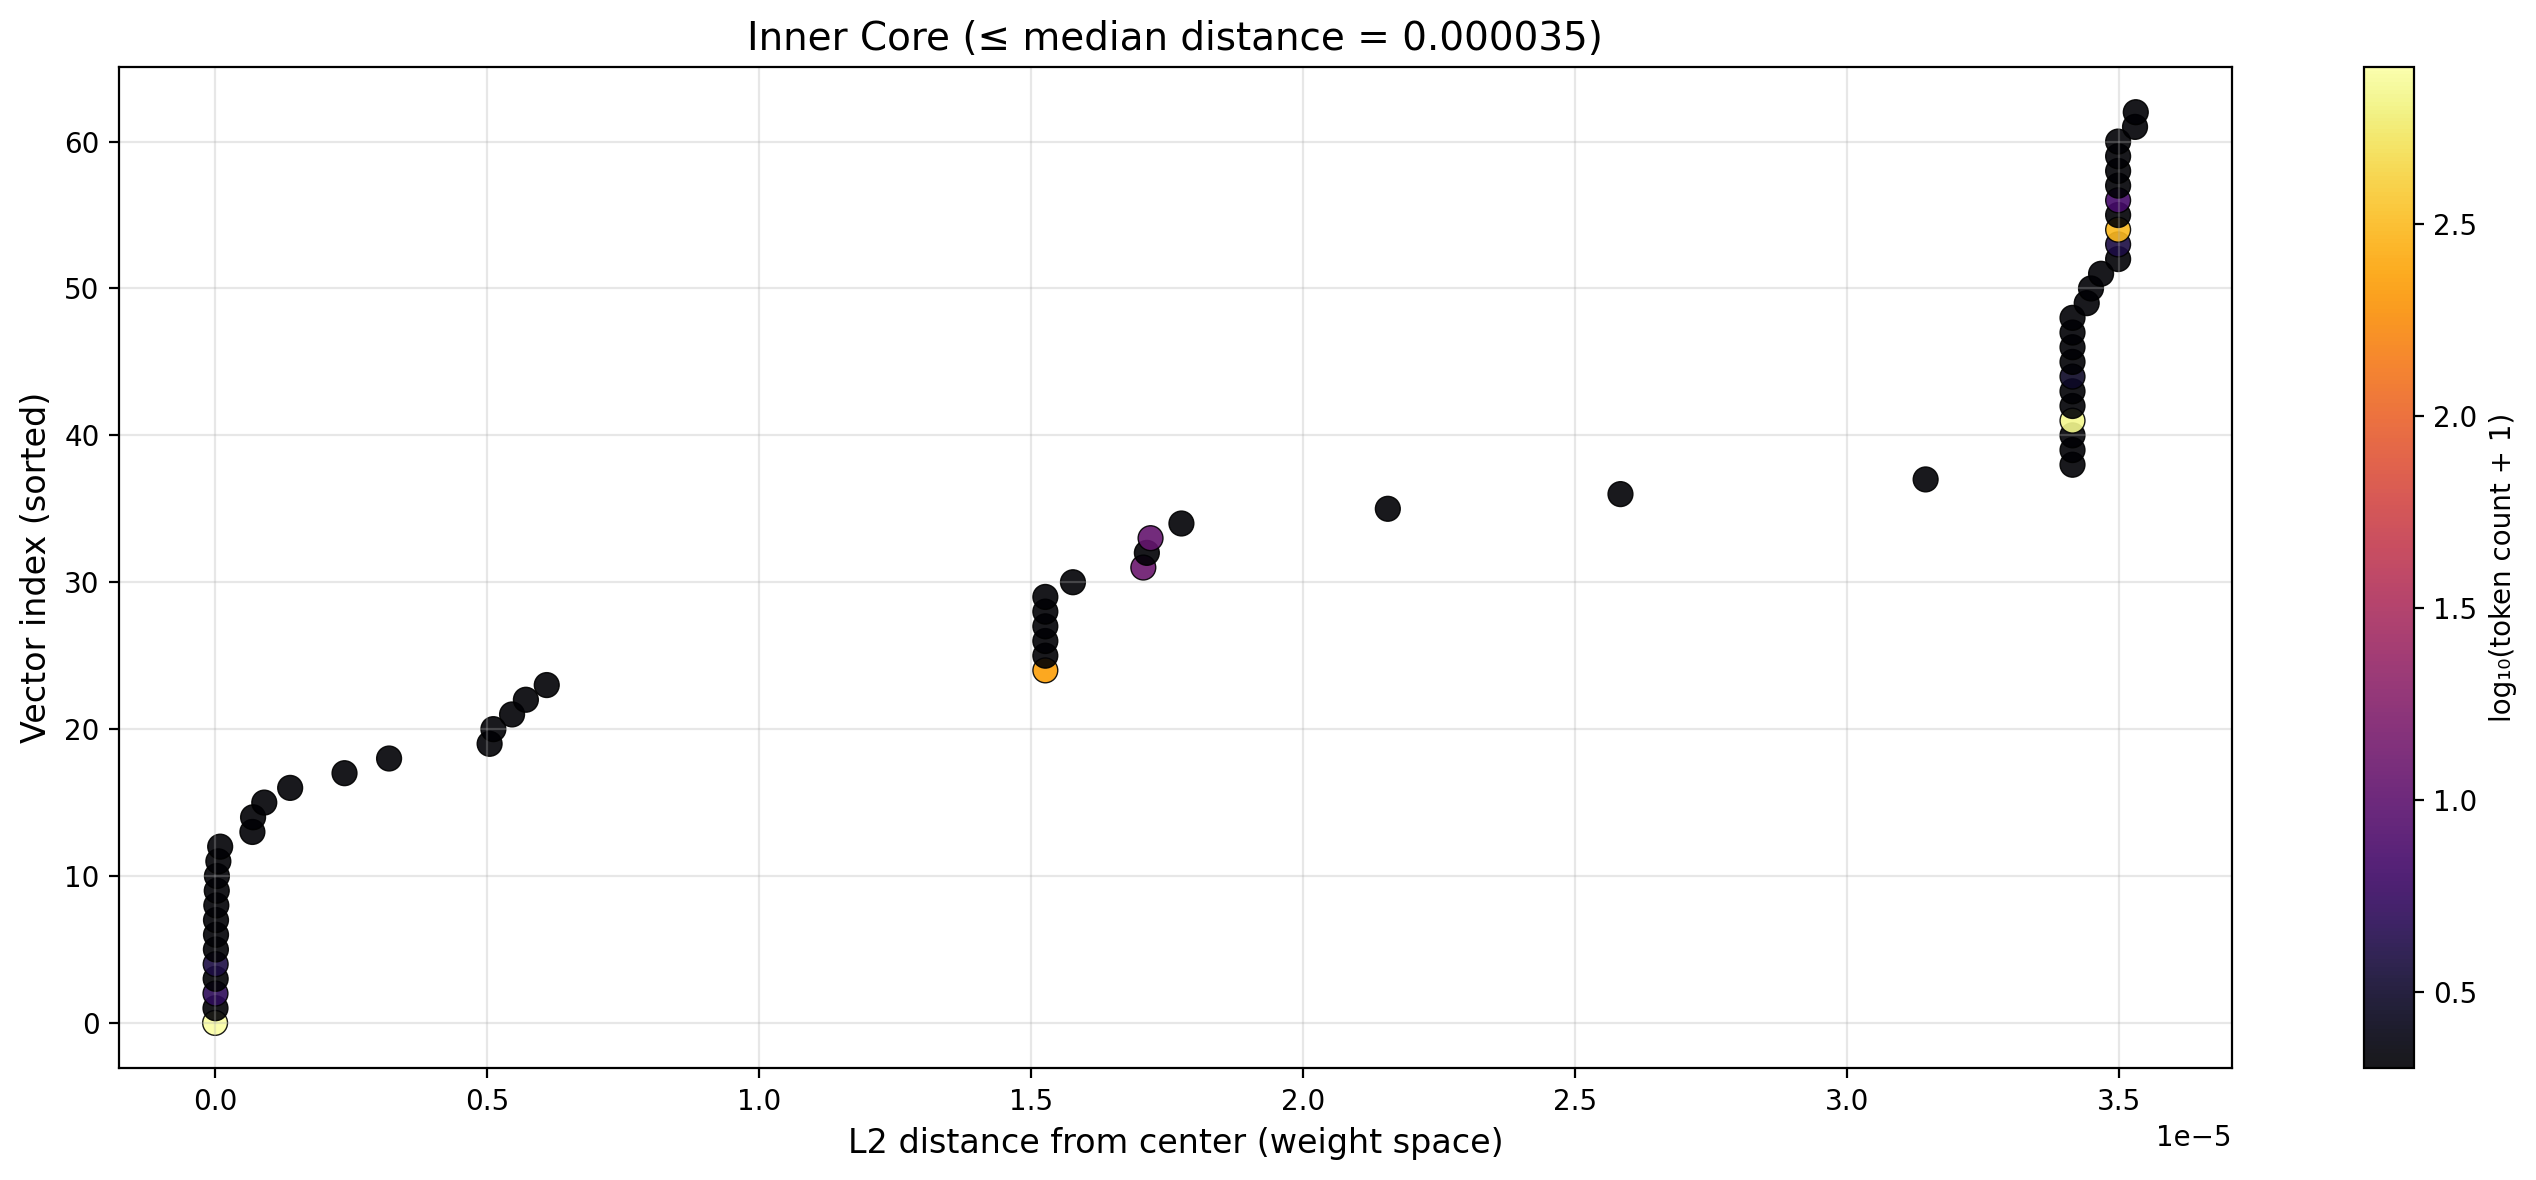


Core statistics:
  Vectors in core: 63
  Tokens in core: 2,143
  Distance range: [0.000000, 0.000035]


In [33]:
# Zoom to inner region (vectors within some percentile)
inner_threshold = np.percentile(r, 50)  # Inner 50% by distance
inner_mask = r <= inner_threshold

r_inner = r[inner_mask]
counts_inner = counts.numpy()[inner_mask]

# Sort
sorted_idx_inner = np.argsort(r_inner)
r_inner_sorted = r_inner[sorted_idx_inner]
counts_inner_sorted = counts_inner[sorted_idx_inner]

fig, ax = plt.subplots(figsize=(14, 6), dpi=200)

colors = np.log10(counts_inner_sorted + 1)
scatter = ax.scatter(r_inner_sorted, np.arange(len(r_inner_sorted)), 
                     c=colors, cmap='inferno', s=80, alpha=0.9,
                     edgecolors='black', linewidths=0.5)

ax.set_xlabel('L2 distance from center (weight space)', fontsize=12)
ax.set_ylabel('Vector index (sorted)', fontsize=12)
ax.set_title(f'Inner Core (≤ median distance = {inner_threshold:.6f})', fontsize=14)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('log₁₀(token count + 1)', fontsize=10)

ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../../notebooks/analysis/weight_l2_core.png', dpi=200, bbox_inches='tight')
plt.show()

print(f"\nCore statistics:")
print(f"  Vectors in core: {inner_mask.sum()}")
print(f"  Tokens in core: {counts_inner.sum():,}")
print(f"  Distance range: [{r_inner.min():.6f}, {r_inner.max():.6f}]")

## Step 6: Cumulative Distribution

What fraction of tokens/vectors are within distance r? This reveals shells clearly.

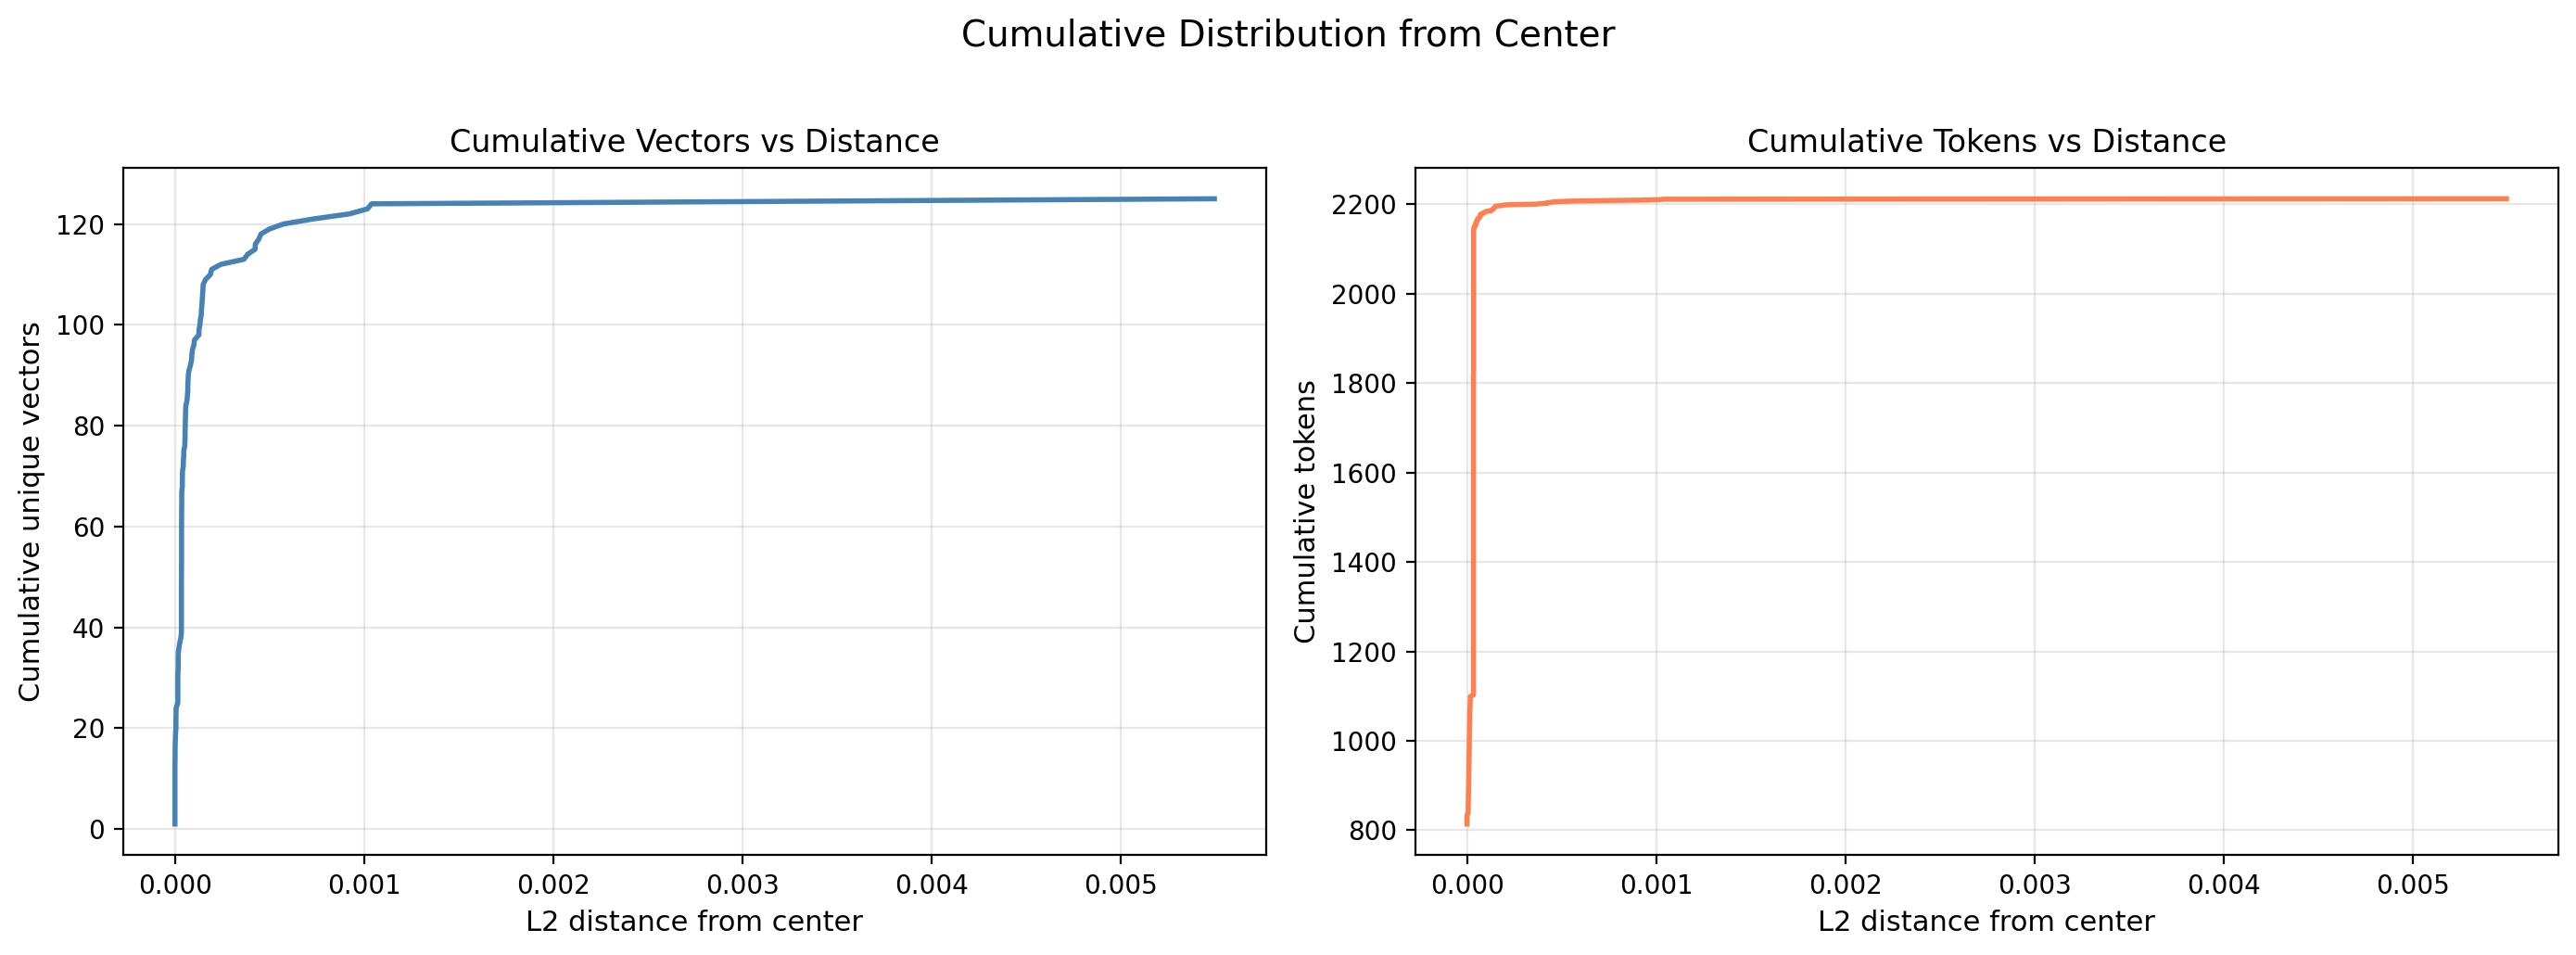

In [34]:
# Cumulative distribution
r_sorted_all = np.sort(r)
counts_by_r = counts.numpy()[np.argsort(r)]

# Cumulative vectors
cum_vectors = np.arange(1, len(r_sorted_all) + 1)

# Cumulative tokens
cum_tokens = np.cumsum(counts_by_r)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=200)

# Left: cumulative vectors
ax = axes[0]
ax.plot(r_sorted_all, cum_vectors, '-', color='steelblue', linewidth=2)
ax.set_xlabel('L2 distance from center', fontsize=11)
ax.set_ylabel('Cumulative unique vectors', fontsize=11)
ax.set_title('Cumulative Vectors vs Distance', fontsize=12)
ax.grid(True, alpha=0.3)

# Right: cumulative tokens
ax = axes[1]
ax.plot(r_sorted_all, cum_tokens, '-', color='coral', linewidth=2)
ax.set_xlabel('L2 distance from center', fontsize=11)
ax.set_ylabel('Cumulative tokens', fontsize=11)
ax.set_title('Cumulative Tokens vs Distance', fontsize=12)
ax.grid(True, alpha=0.3)

plt.suptitle('Cumulative Distribution from Center', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../../notebooks/analysis/weight_l2_cumulative.png', dpi=200, bbox_inches='tight')
plt.show()

## Step 7: Nearest Neighbor Analysis

For each vector, what's its distance to its nearest neighbor?

In [35]:
# k-NN in weight space
K = 5

# Set diagonal to inf
l2_for_knn = l2_matrix.clone()
l2_for_knn.fill_diagonal_(float('inf'))

# Get k nearest neighbors
knn_dists, knn_indices = torch.topk(l2_for_knn, K, dim=1, largest=False)

# Nearest neighbor distance for each vector
nn_dist = knn_dists[:, 0].numpy()

print(f"Nearest neighbor distances:")
print(f"  Min: {nn_dist.min():.6f}")
print(f"  Mean: {nn_dist.mean():.6f}")
print(f"  Median: {np.median(nn_dist):.6f}")
print(f"  Max: {nn_dist.max():.6f}")

Nearest neighbor distances:
  Min: 0.000000
  Mean: 0.000134
  Median: 0.000017
  Max: 0.005490


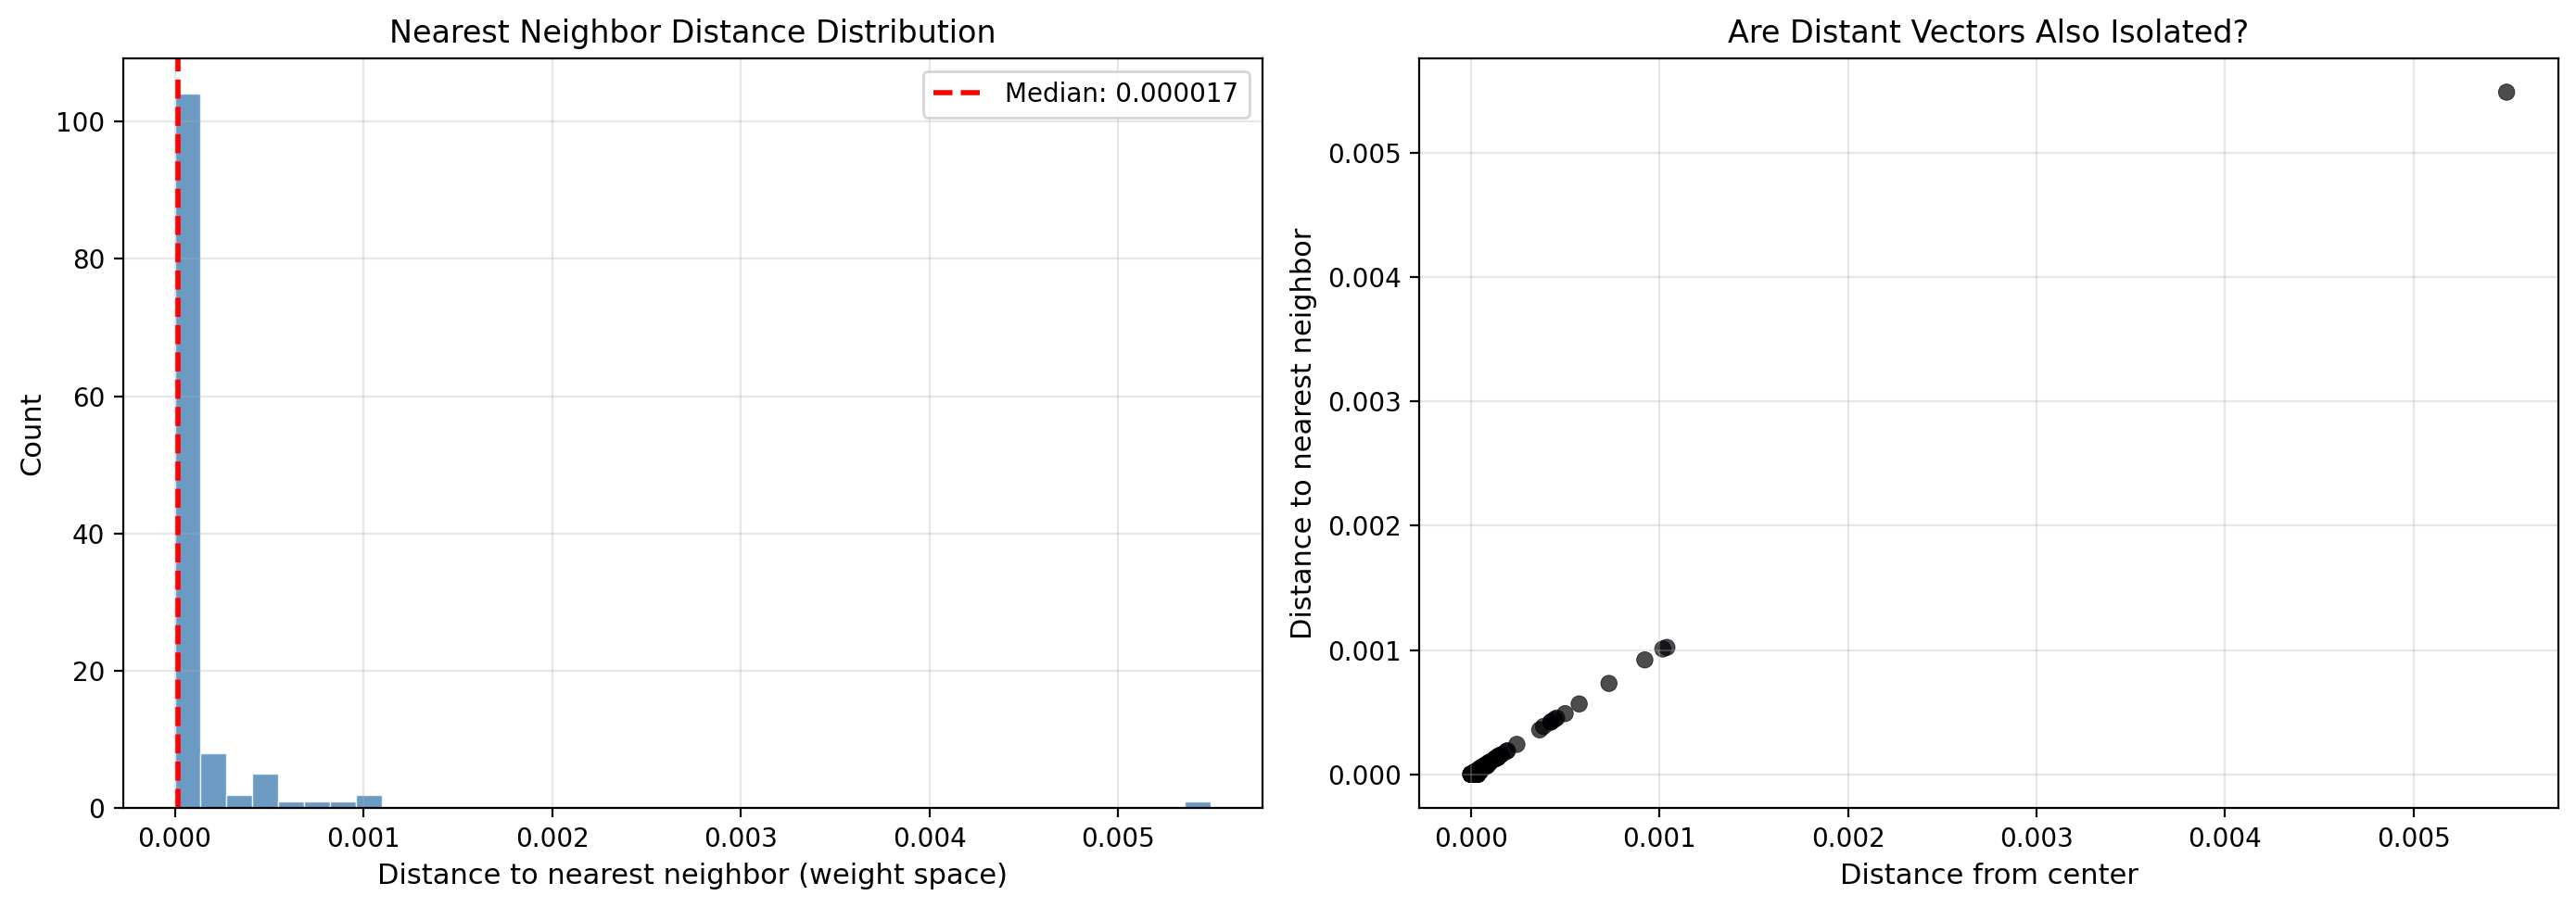

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=200)

# Left: histogram of NN distances
ax = axes[0]
ax.hist(nn_dist, bins=40, color='steelblue', edgecolor='white', linewidth=0.5, alpha=0.8)
ax.axvline(np.median(nn_dist), color='red', linestyle='--', linewidth=2, 
           label=f'Median: {np.median(nn_dist):.6f}')
ax.set_xlabel('Distance to nearest neighbor (weight space)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Nearest Neighbor Distance Distribution', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

# Right: NN distance vs distance from center (are outliers isolated?)
ax = axes[1]
ax.scatter(r, nn_dist, c=np.log10(counts.numpy() + 1), cmap='inferno', 
           s=40, alpha=0.7, edgecolors='black', linewidths=0.3)
ax.set_xlabel('Distance from center', fontsize=11)
ax.set_ylabel('Distance to nearest neighbor', fontsize=11)
ax.set_title('Are Distant Vectors Also Isolated?', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../notebooks/analysis/weight_l2_nn.png', dpi=200, bbox_inches='tight')
plt.show()

## Step 8: The Outlier

That lonely point at distance ~0.0055 with nearest-neighbor distance also ~0.0055 is suspicious. We selected the neighborhood as tokens within L∞ ≤ 5 *exponents* of the biggest black hole—and the minimum count at that boundary was exactly 1.

Let's find this outlier and verify it's sitting at the exponent boundary.

In [37]:
# Find the outlier: vector with max distance from center
outlier_idx = np.argmax(r)
outlier_dist = r[outlier_idx]
outlier_nn_dist = nn_dist[outlier_idx]
outlier_tokens = counts[outlier_idx].item()

print(f"OUTLIER IDENTIFICATION")
print(f"  Index in unique vectors: {outlier_idx}")
print(f"  Distance from center: {outlier_dist:.6f}")
print(f"  Distance to nearest neighbor: {outlier_nn_dist:.6f}")
print(f"  Token count: {outlier_tokens}")

# Get the actual weight vectors
W_center = W_unique[center_idx]  # The biggest black hole
W_outlier = W_unique[outlier_idx]

# Extract exponents from bfloat16
def get_exponents_bf16(tensor_bf16):
    """Extract the 8-bit exponent field from bfloat16 values."""
    bits = tensor_bf16.view(torch.uint16).to(torch.int32)
    exponents = (bits >> 7) & 0xFF
    return exponents

center_bf16 = unique_bf16[center_idx]
outlier_bf16 = unique_bf16[outlier_idx]

center_exp = get_exponents_bf16(center_bf16)
outlier_exp = get_exponents_bf16(outlier_bf16)

# Compute exponent difference (L∞ in exponent space)
exp_diff = (outlier_exp - center_exp).abs()
max_exp_diff = exp_diff.max().item()

print(f"\nEXPONENT ANALYSIS")
print(f"  Max exponent difference (L∞): {max_exp_diff}")
print(f"  (Neighborhood was defined as L∞ ≤ 5 exponents)")

# How many dimensions differ by exactly 5?
dims_at_boundary = (exp_diff == 5).sum().item()
print(f"  Dimensions at exactly 5 exponents: {dims_at_boundary}")

# Distribution of exponent differences
print(f"\nExponent difference distribution:")
for i in range(6):
    count = (exp_diff == i).sum().item()
    print(f"  |ΔE| = {i}: {count} dimensions")

# WHAT IS THE OUTLIER?
print("\n" + "=" * 60)
print("WHAT IS THE OUTLIER?")
print("=" * 60)

# Find which token(s) map to The Outlier's unique vector
tokens_at_outlier = []
for i, orig_idx in enumerate(neighborhood_indices):
    if inverse_indices[i] == outlier_idx:
        tokens_at_outlier.append(orig_idx.item())

print(f"\nToken index(es) at The Outlier position: {tokens_at_outlier}")

# Decode the token
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-4B-Instruct-2507")

for tok_idx in tokens_at_outlier:
    decoded = tokenizer.decode([tok_idx])
    # Check for Thai script (Unicode range U+0E00 to U+0E7F)
    is_thai = any('\u0e00' <= c <= '\u0e7f' for c in decoded)
    # Check for CJK (common ranges)
    is_cjk = any('\u4e00' <= c <= '\u9fff' or '\u3400' <= c <= '\u4dbf' for c in decoded)
    
    print(f"\n  Token {tok_idx}:")
    print(f"    Decoded: {repr(decoded)}")
    print(f"    Thai script: {is_thai}")
    print(f"    CJK: {is_cjk}")
    print(f"    Bytes: {decoded.encode('utf-8').hex()}")

print("\n" + "-" * 60)
print("NOTE: We don't have ground truth about which Qwen tokens are")
print("'dead' (never appear in training). We infer it from the fact")
print("that ~1,800 tokens in this overdensity are Thai script, and")
print("tokenizing Thai Wikipedia yields ZERO of these tokens.")
print("-" * 60)

OUTLIER IDENTIFICATION
  Index in unique vectors: 0
  Distance from center: 0.005495
  Distance to nearest neighbor: 0.005490
  Token count: 1

EXPONENT ANALYSIS
  Max exponent difference (L∞): 5
  (Neighborhood was defined as L∞ ≤ 5 exponents)
  Dimensions at exactly 5 exponents: 4

Exponent difference distribution:
  |ΔE| = 0: 2349 dimensions
  |ΔE| = 1: 185 dimensions
  |ΔE| = 2: 15 dimensions
  |ΔE| = 3: 2 dimensions
  |ΔE| = 4: 5 dimensions
  |ΔE| = 5: 4 dimensions

WHAT IS THE OUTLIER?

Token index(es) at The Outlier position: [27487]

  Token 27487:
    Decoded: '��取'
    Thai script: False
    CJK: True
    Bytes: efbfbdefbfbde58f96

------------------------------------------------------------
NOTE: We don't have ground truth about which Qwen tokens are
'dead' (never appear in training). We infer it from the fact
that ~1,800 tokens in this overdensity are Thai script, and
tokenizing Thai Wikipedia yields ZERO of these tokens.
----------------------------------------------------

<cell_type>markdown</cell_type>## Step 9: The Oort Cloud

Is The Outlier alone, or just the closest member of a distant population? Let's look at the sparse middle ground between the dense core and The Outlier—and beyond.

In [38]:
# Look at the distance distribution more carefully
# Particularly the sparse region between core and Outlier

r_sorted_idx = np.argsort(r)
r_sorted = r[r_sorted_idx]
counts_sorted = counts.numpy()[r_sorted_idx]

# Find natural breaks in the distribution
print("DISTANCE DISTRIBUTION (all 125 vectors)")
print("=" * 70)

# Percentiles
percentiles = [50, 75, 90, 95, 99]
print("\nPercentiles:")
for p in percentiles:
    val = np.percentile(r, p)
    print(f"  {p}th percentile: {val:.6f}")

print(f"\nMax (The Outlier): {r.max():.6f}")

# Look at vectors in different distance bands
bands = [
    (0, 0.00005, "Core (L2 < 0.00005)"),
    (0.00005, 0.0001, "Inner (0.00005-0.0001)"),
    (0.0001, 0.0005, "Middle (0.0001-0.0005)"),
    (0.0005, 0.001, "Outer (0.0005-0.001)"),
    (0.001, 0.005, "Sparse (0.001-0.005)"),
    (0.005, 0.01, "Oort Cloud (>0.005)"),
]

print("\n" + "=" * 70)
print("DISTANCE BANDS")
print("=" * 70)

for lo, hi, name in bands:
    mask = (r >= lo) & (r < hi)
    n_vectors = mask.sum()
    n_tokens = counts.numpy()[mask].sum() if n_vectors > 0 else 0
    print(f"\n{name}:")
    print(f"  Vectors: {n_vectors}")
    print(f"  Tokens: {n_tokens}")
    if n_vectors > 0 and n_vectors <= 10:
        # Show details for sparse regions
        idxs = np.where(mask)[0]
        for idx in idxs:
            print(f"    idx={idx}, r={r[idx]:.6f}, tokens={counts[idx].item()}")

DISTANCE DISTRIBUTION (all 125 vectors)

Percentiles:
  50th percentile: 0.000035
  75th percentile: 0.000089
  90th percentile: 0.000316
  95th percentile: 0.000490
  99th percentile: 0.001034

Max (The Outlier): 0.005495

DISTANCE BANDS

Core (L2 < 0.00005):
  Vectors: 75
  Tokens: 2159

Inner (0.00005-0.0001):
  Vectors: 21
  Tokens: 24

Middle (0.0001-0.0005):
  Vectors: 23
  Tokens: 23

Outer (0.0005-0.001):
  Vectors: 3
  Tokens: 3
    idx=2, r=0.000732, tokens=1
    idx=121, r=0.000574, tokens=1
    idx=124, r=0.000922, tokens=1

Sparse (0.001-0.005):
  Vectors: 2
  Tokens: 2
    idx=1, r=0.001039, tokens=1
    idx=122, r=0.001018, tokens=1

Oort Cloud (>0.005):
  Vectors: 1
  Tokens: 1
    idx=0, r=0.005495, tokens=1


In [39]:
# Now let's look BEYOND our neighborhood selection
# The Outlier is at the edge of L∞ ≤ 5 exponents
# What if there are more "mostly dead" tokens at L∞ = 6, 7, 8... ?

# We need to search the FULL vocabulary for tokens near the overdensity
# but outside our current selection

print("=" * 70)
print("SEARCHING FOR THE OORT CLOUD")
print("=" * 70)
print("\nLooking beyond L∞ ≤ 5 exponents from the black hole center...")

# Get the center (biggest black hole) in the full W matrix
# First find which original token index corresponds to our center
center_tokens = []
for i, orig_idx in enumerate(neighborhood_indices):
    if inverse_indices[i] == center_idx:
        center_tokens.append(orig_idx.item())

center_token_idx = center_tokens[0]  # Pick one (they're all at same position)
W_center_full = W[center_token_idx].float()

print(f"\nCenter token index: {center_token_idx}")
print(f"Center position (first 5 dims): {W_center_full[:5].tolist()}")

# Compute L2 distance from center for ALL tokens
W_all = W.float()  # [151936, 2560]
dist_from_center_all = torch.norm(W_all - W_center_full, dim=1).numpy()

print(f"\nDistance statistics for ALL {len(dist_from_center_all):,} tokens:")
print(f"  Min: {dist_from_center_all.min():.6f}")
print(f"  Max: {dist_from_center_all.max():.6f}")
print(f"  Mean: {dist_from_center_all.mean():.6f}")

# The Outlier is at 0.005495
# Let's look for tokens in the "Oort Cloud" range: 0.005 to 0.05 (10x)
oort_mask = (dist_from_center_all >= 0.005) & (dist_from_center_all < 0.05)
n_oort = oort_mask.sum()

print(f"\n'Oort Cloud' candidates (0.005 ≤ L2 < 0.05): {n_oort} tokens")

SEARCHING FOR THE OORT CLOUD

Looking beyond L∞ ≤ 5 exponents from the black hole center...

Center token index: 80091
Center position (first 5 dims): [0.006072998046875, 0.01324462890625, 0.01177978515625, 0.03662109375, 0.015869140625]

Distance statistics for ALL 151,936 tokens:
  Min: 0.000000
  Max: 1.571872
  Mean: 1.050221

'Oort Cloud' candidates (0.005 ≤ L2 < 0.05): 87 tokens


In [40]:
# Let's examine the Oort Cloud candidates more carefully
if n_oort > 0:
    oort_indices = np.where(oort_mask)[0]
    oort_distances = dist_from_center_all[oort_mask]
    
    # Sort by distance
    sort_idx = np.argsort(oort_distances)
    oort_indices_sorted = oort_indices[sort_idx]
    oort_distances_sorted = oort_distances[sort_idx]
    
    print(f"\nOort Cloud members (sorted by distance from black hole center):")
    print(f"{'Rank':>4} {'Token':>8} {'L2 dist':>12} {'In neighborhood?':>18} {'Decoded':>30}")
    print("-" * 80)
    
    for i, (tok_idx, dist) in enumerate(zip(oort_indices_sorted[:30], oort_distances_sorted[:30])):
        in_neighborhood = neighborhood_mask[tok_idx].item()
        decoded = tokenizer.decode([tok_idx])
        # Truncate for display
        decoded_short = repr(decoded)[:28]
        print(f"{i+1:>4} {tok_idx:>8} {dist:>12.6f} {str(in_neighborhood):>18} {decoded_short:>30}")
    
    if n_oort > 30:
        print(f"... and {n_oort - 30} more")
    
    # How many are in vs out of our neighborhood selection?
    in_hood = neighborhood_mask[oort_indices].sum()
    out_hood = n_oort - in_hood
    print(f"\nOf {n_oort} Oort Cloud tokens:")
    print(f"  In neighborhood (L∞ ≤ 5 exp): {in_hood}")
    print(f"  Outside neighborhood: {out_hood}")
else:
    print("\nNo Oort Cloud candidates found in this range.")


Oort Cloud members (sorted by distance from black hole center):
Rank    Token      L2 dist   In neighborhood?                        Decoded
--------------------------------------------------------------------------------
   1    27487     0.005495               True                          '��取'
   2   151653     0.006882              False               '<|vision_end|>'
   3   151652     0.007598              False             '<|vision_start|>'
   4   142386     0.007800              False                     ' zwłaszc'
   5    88372     0.008590              False                  'useRalative'
   6   127734     0.009263              False                        'פייסב'
   7   136954     0.009575              False                         'טלוו'
   8   127572     0.014709              False                           'ו�'
   9    88371     0.016145              False                       'useRal'
  10   151300     0.016386              False                            '𝇠'
  11   

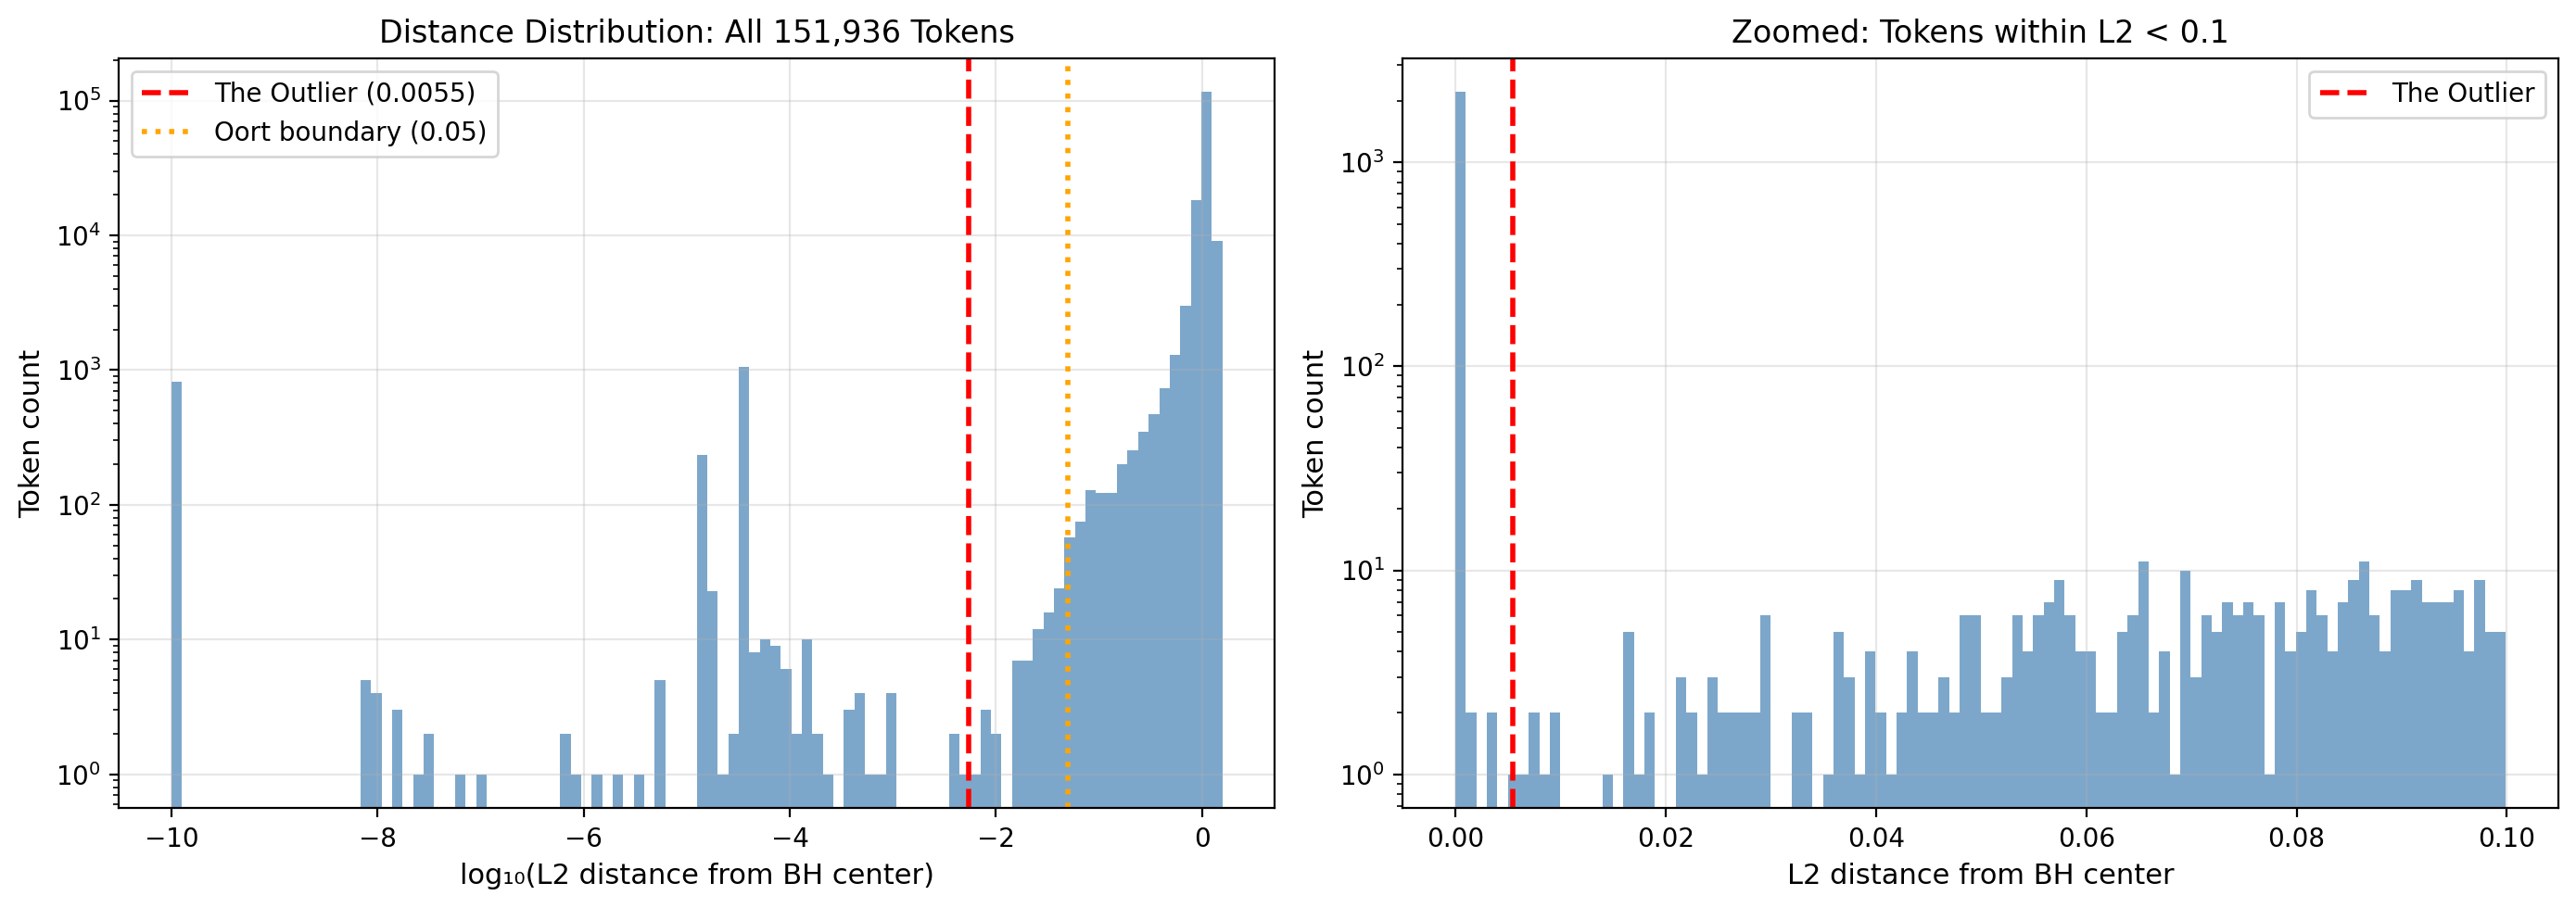


Tokens within L2 < 0.1 of BH center: 2,586


In [43]:
# Visualize the full distance distribution from the black hole center
# This will show us if there's a gap, a gradual tail, or an Oort Cloud structure

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=200)

# Left: Histogram of ALL tokens by distance from BH center
ax = axes[0]
# Use log scale for distance to see structure
log_dist = np.log10(dist_from_center_all + 1e-10)
ax.hist(log_dist, bins=100, color='steelblue', edgecolor='none', alpha=0.7)
ax.axvline(np.log10(0.005495), color='red', linestyle='--', linewidth=2, 
           label=f'The Outlier ({0.005495:.4f})')
ax.axvline(np.log10(0.05), color='orange', linestyle=':', linewidth=2,
           label='Oort boundary (0.05)')
ax.set_xlabel('log₁₀(L2 distance from BH center)', fontsize=11)
ax.set_ylabel('Token count', fontsize=11)
ax.set_title('Distance Distribution: All 151,936 Tokens', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

ax.set_yscale('log')

# Right: Zoom in on the near region (0 to 0.1)
ax = axes[1]
near_mask = dist_from_center_all < 0.1
near_dist = dist_from_center_all[near_mask]
ax.hist(near_dist, bins=100, color='steelblue', edgecolor='none', alpha=0.7)
ax.axvline(0.005495, color='red', linestyle='--', linewidth=2, 
           label=f'The Outlier')
ax.set_xlabel('L2 distance from BH center', fontsize=11)
ax.set_ylabel('Token count', fontsize=11)
ax.set_title('Zoomed: Tokens within L2 < 0.1', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

ax.set_yscale('log')

plt.tight_layout()
plt.savefig('../../notebooks/analysis/oort_cloud_search.png', dpi=200, bbox_inches='tight')
plt.show()

print(f"\nTokens within L2 < 0.1 of BH center: {near_mask.sum():,}")

## Summary

In [ ]:
print("=" * 70)
print("WEIGHT-SPACE EUCLIDEAN STRUCTURE SUMMARY")
print("=" * 70)
print()
print(f"Vectors in neighborhood: {n_unique}")
print(f"Tokens in neighborhood: {counts.sum().item():,}")
print(f"Dimensionality: {D}")
print()
print("VECTOR MAGNITUDES (distance from origin):")
print(f"  Mean: {norms.mean():.6f}")
print(f"  Range: [{norms.min():.6f}, {norms.max():.6f}]")
print(f"  Variation: {(norms.max() - norms.min()) / norms.mean() * 100:.3f}%")
print()
print("DISTANCE FROM BLACK HOLE CENTER:")
print(f"  Median: {np.median(r):.6f}")
print(f"  Max (The Outlier): {r.max():.6f}")
print()
print("THE OUTLIER:")
print(f"  Token: {tokens_at_outlier[0]} = {repr(tokenizer.decode(tokens_at_outlier))}")
print(f"  Distance from center: {outlier_dist:.6f}")
print(f"  Exponent difference (L∞): {max_exp_diff}")
print()
print("KEY INSIGHTS:")
print(f"  1. The overdensity spans only {r.max() / norms.mean() * 100:.2f}% of distance to origin")
print(f"  2. All vectors have nearly identical magnitude (<0.1% variation)")
print(f"  3. The Outlier sits at the L∞=5 exponent boundary")
print(f"  4. The void between core and Outlier suggests discrete 'kicks'")
print(f"  5. Hypothesis: The Outlier is 'mostly dead' - got 1 early gradient update")

WEIGHT-SPACE EUCLIDEAN STRUCTURE SUMMARY

Vectors in neighborhood: 125
Tokens in neighborhood: 2,212
Dimensionality: 2560

VECTOR MAGNITUDES (distance from origin):
  Mean: 0.370915
  Range: [0.370653, 0.370957]
  Variation: 0.082%

DISTANCE FROM BLACK HOLE CENTER:
  Median: 0.000035
  Max (The Outlier): 0.005495

THE OUTLIER:
  Token: 27487 = '��取'
  Distance from center: 0.005495
  Exponent difference (L∞): 5

KEY INSIGHTS:
  1. The overdensity spans only 1.48% of distance to origin
  2. All vectors have nearly identical magnitude (<0.1% variation)
  3. The Outlier sits at the L∞=5 exponent boundary
  4. The void between core and Outlier suggests discrete 'kicks'
  5. Hypothesis: The Outlier is 'mostly dead' - got 1 early gradient update


: 